In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.models import save_model, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from math import floor


# Keeping this as a reference for how we created the data
#train1 = pd.read_csv('train_1.csv', sep=',', header=0)
#train2 = pd.read_csv('train_2.csv', sep=',', header=0)
#train3 = pd.read_csv('train_3.csv', sep=',', header=0)
#train4 = pd.read_csv('train_4.csv', sep=',', header=0)
#train = pd.concat([train1, train2, train3, train4], ignore_index=True)
#test = pd.read_csv('test.csv', header=0)
#train = train[train['store_nbr'] == 1]
#train = train.drop(columns=["id", "store_nbr"], axis=1)
#train_data = train.pivot_table(index=['date'], columns="family", values='sales')
#train_data["total_sales"] = train_data[list(train_data.columns[1:])].sum(axis=1)
#amt = floor(len(train_data)*.8)
#test_data = train_data[amt:]
#train_data = train_data[:amt]



In [2]:
def parse_data(column_index, scaler):

    store_1_data = pd.read_csv("train_data_store_1.csv")
    if column_index == (len(store_1_data.columns)-1):
        total_sales = store_1_data.iloc[:,-1:].values
    else:
        total_sales = store_1_data.iloc[:, column_index: (column_index+1 if (column_index+1) <= (len(store_1_data.columns) - 1) else -1) ].values
 
    training_set = total_sales[:floor(len(total_sales)*.8)]
    testing_set = total_sales[floor(len(total_sales)*.8):]
    scaled_data = scaler.fit_transform(training_set)
    X_train = []
    y_train = []
    for i in range(14, len(training_set)):
        X_train.append(scaled_data[i-14:i, 0])
        y_train.append(scaled_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train, y_train, total_sales, training_set, testing_set
def create_model(X_train):
    model = Sequential()
    model.add(LSTM(units=55, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=55, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=55, return_sequences=True))
    model.add(LSTM(units=55))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
    return model







In [3]:

def train_fit_predict(column_index, epochs, batch_size):
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train, y_train, column_data, training_set, testing_set = parse_data(column_index, scaler)
    model = create_model(X_train)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)
    total_sales = column_data
    data = pd.DataFrame(total_sales[len(total_sales) - len(testing_set) - 14:]).values
    data = data.reshape(-1, 1)
    data = scaler.transform(data)
    X_test = []
    for i in range(14, len(testing_set)):
        X_test.append(data[i-14:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred = model.predict(X_test)
    pred = scaler.inverse_transform(pred)
    eval_res = model.evaluate(X_train, y_train, verbose=False)
    return pred, testing_set, eval_res

In [4]:
#Save model
#model.save('austin_model_save')

In [5]:
#Load model
#model = load_model('austin_model_save')

In [6]:
def predict_column(column_index_to_test, epochs, batch_size):
    pred, testing_set, eval_res= train_fit_predict(column_index_to_test, epochs, batch_size)
    print(f"Evaluation loss: {eval_res}")
    colNames = pd.read_csv("train_data_store_1.csv").columns
    #plt.plot(testing_set[:-14], color='blue', label=f'{colNames[column_index_to_test]} Sales')
    #plt.plot(pred, color='red', label=f'{colNames[column_index_to_test]} Predicted Total Sales')
    #plt.title(f"Store 1 {colNames[column_index_to_test].title()} sales")
    #plt.legend()
    return testing_set[:-14], pred, colNames[column_index_to_test].title()

Epoch 1/40
75/75 [==============================] - 7s 26ms/step - loss: 0.0152 - val_loss: 0.0160
Epoch 2/40
75/75 [==============================] - 1s 13ms/step - loss: 0.0144 - val_loss: 0.0160
Epoch 3/40
75/75 [==============================] - 1s 13ms/step - loss: 0.0139 - val_loss: 0.0164
Epoch 4/40
75/75 [==============================] - 1s 13ms/step - loss: 0.0136 - val_loss: 0.0202
Epoch 5/40
75/75 [==============================] - 1s 13ms/step - loss: 0.0139 - val_loss: 0.0179
Epoch 6/40
75/75 [==============================] - 1s 13ms/step - loss: 0.0136 - val_loss: 0.0195
Epoch 7/40
75/75 [==============================] - 1s 13ms/step - loss: 0.0138 - val_loss: 0.0181
Epoch 8/40
75/75 [==============================] - 1s 13ms/step - loss: 0.0138 - val_loss: 0.0174
Epoch 9/40
75/75 [==============================] - 1s 13ms/step - loss: 0.0136 - val_loss: 0.0168
Epoch 10/40
75/75 [==============================] - 1s 13ms/step - loss: 0.0135 - val_loss: 0.0177
Epoch 11/

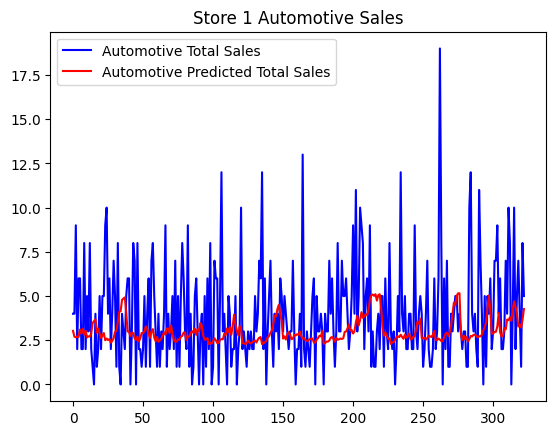

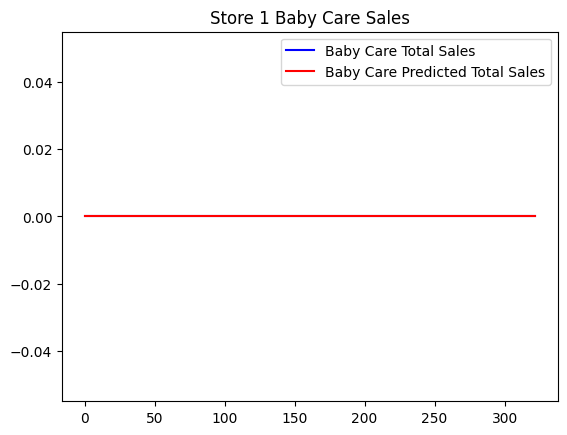

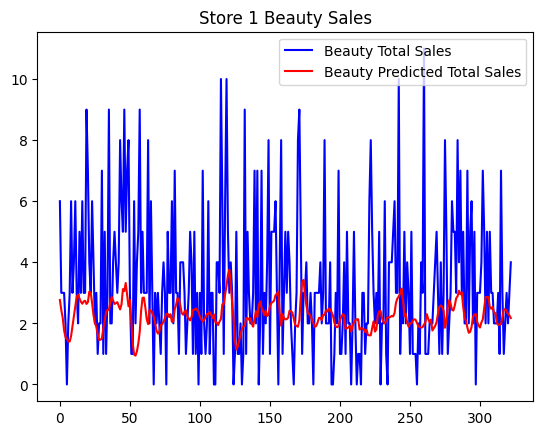

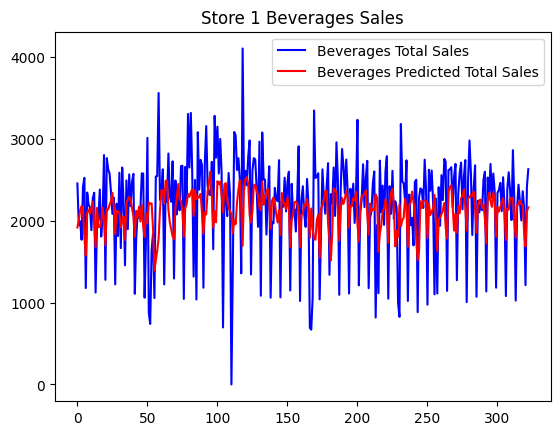

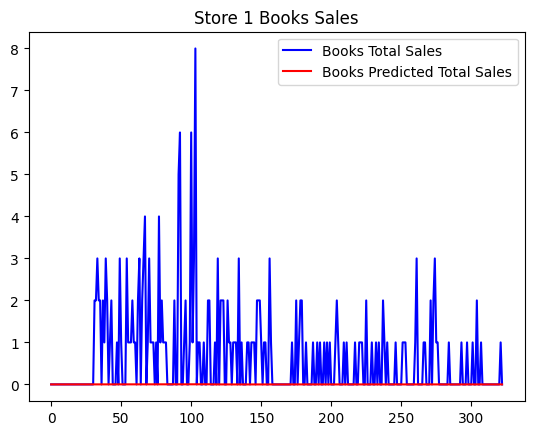

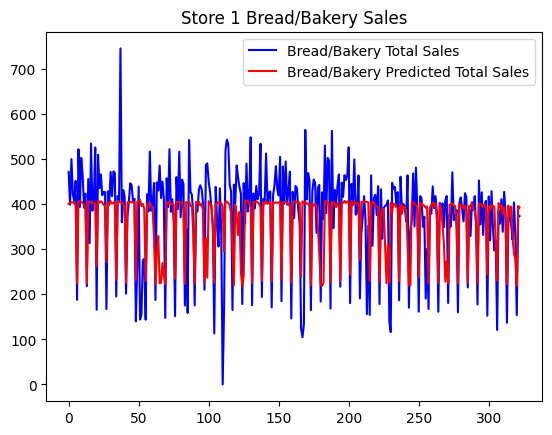

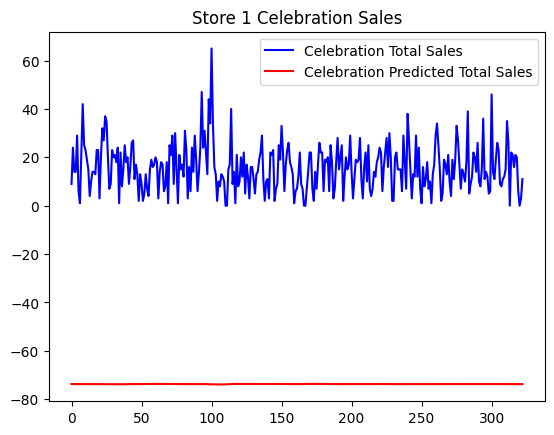

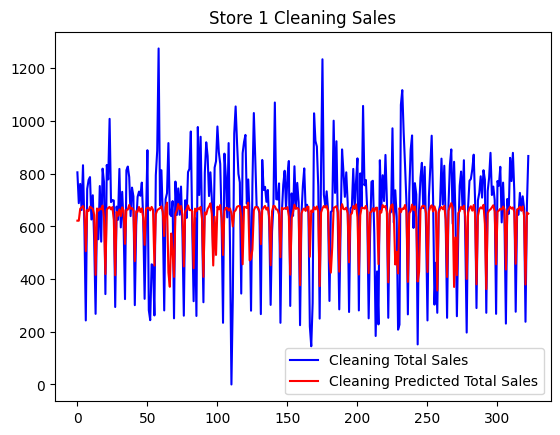

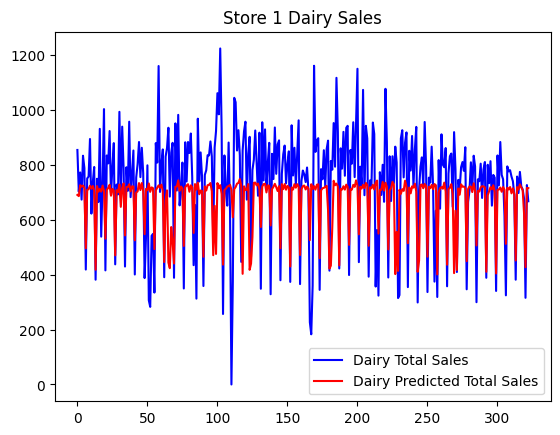

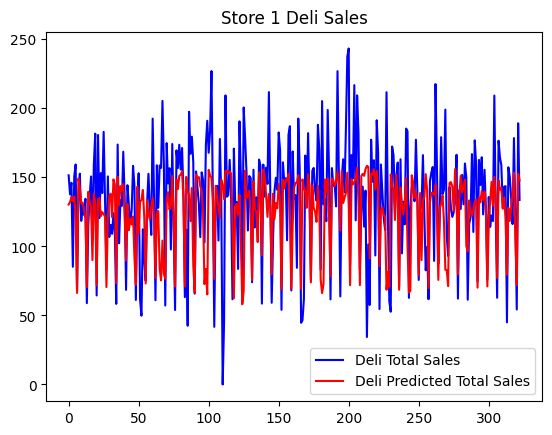

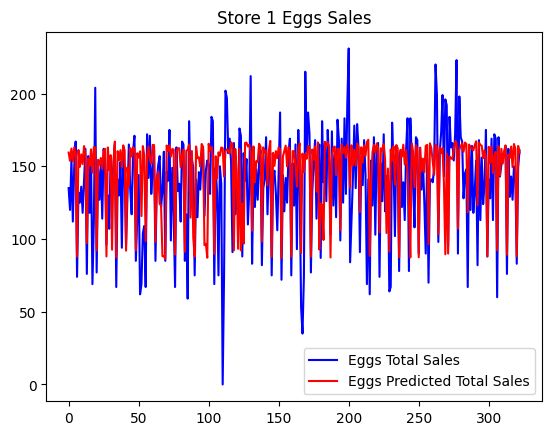

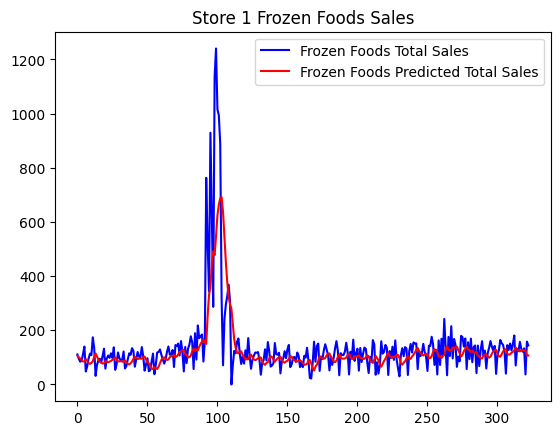

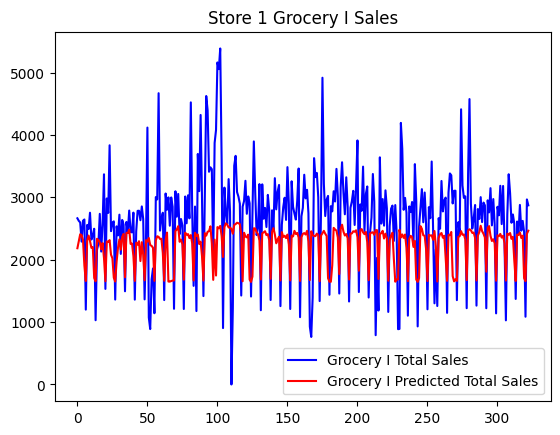

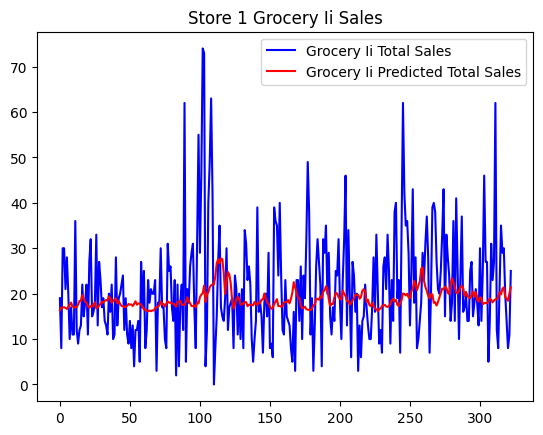

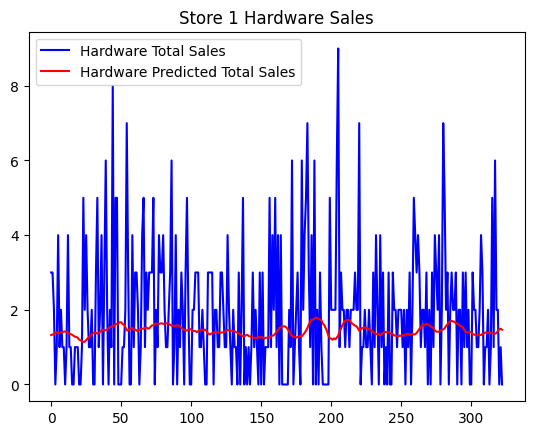

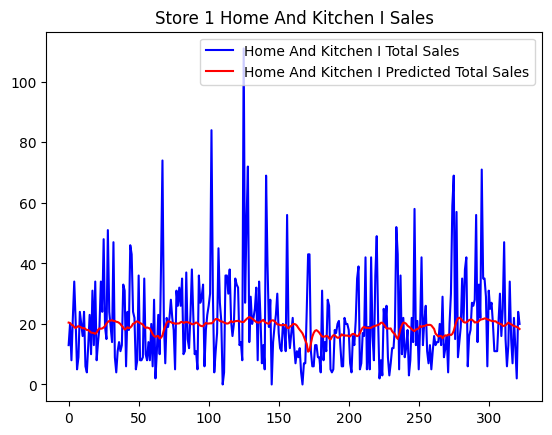

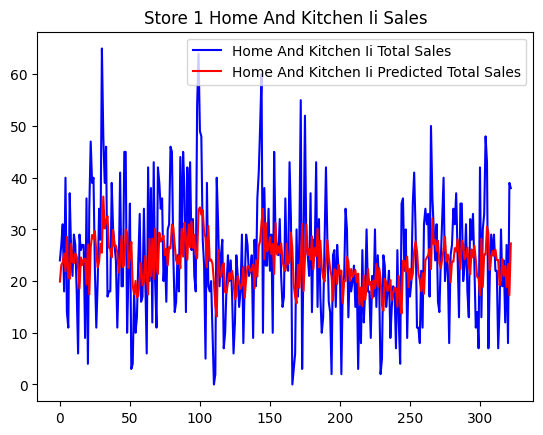

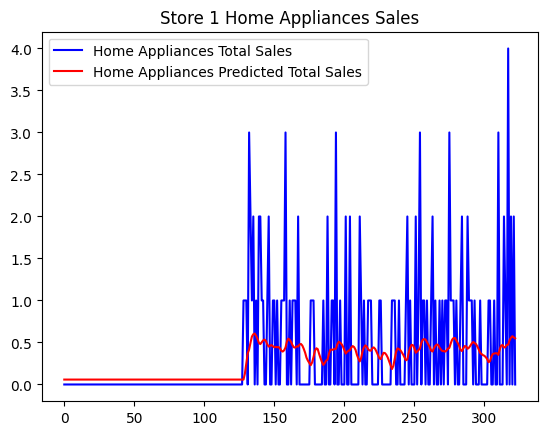

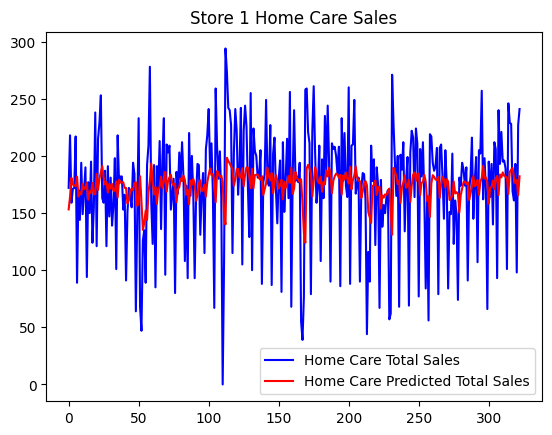

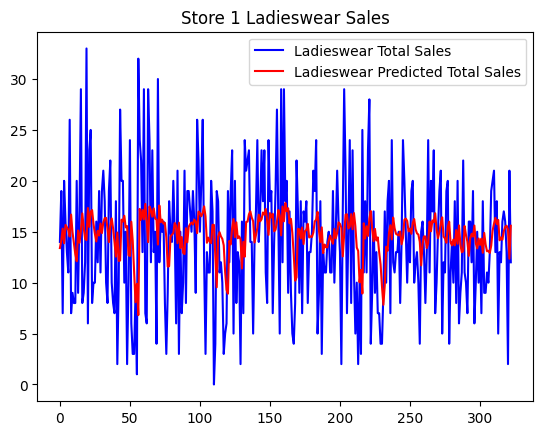

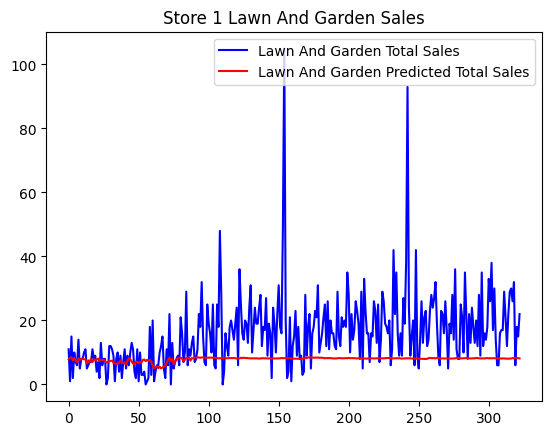

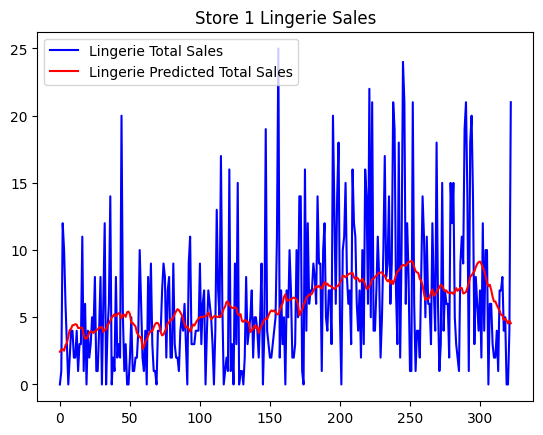

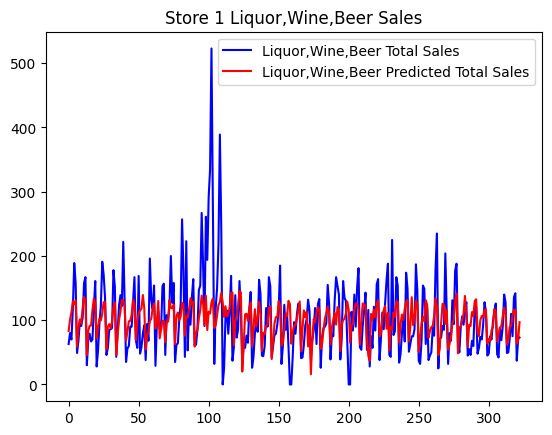

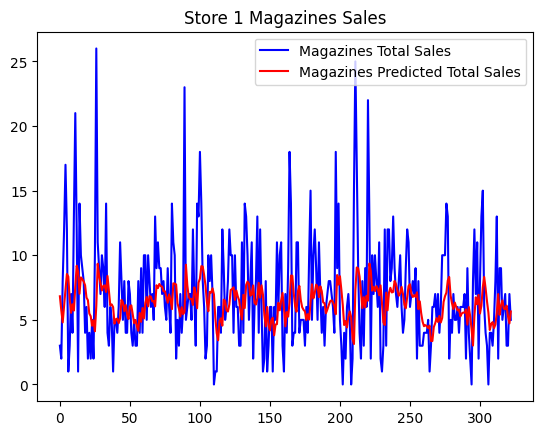

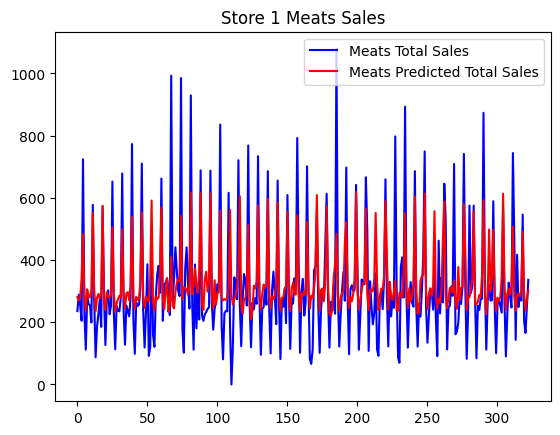

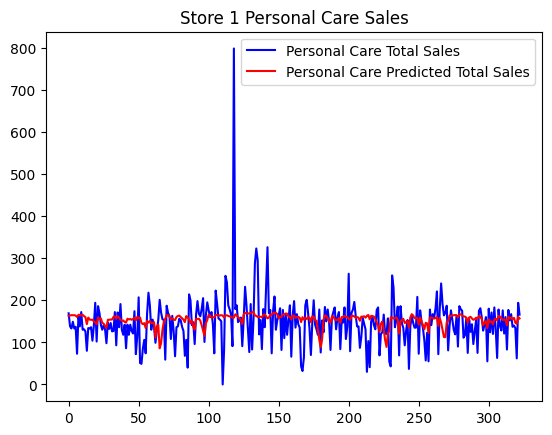

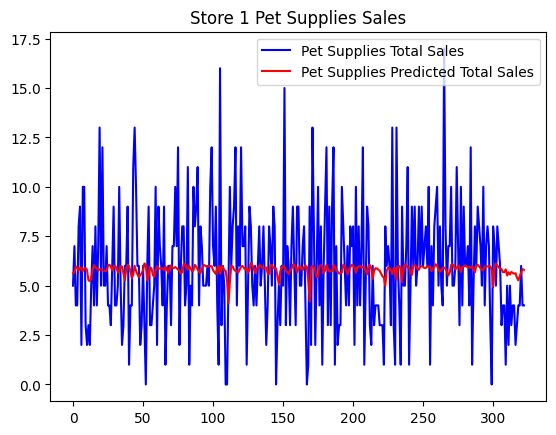

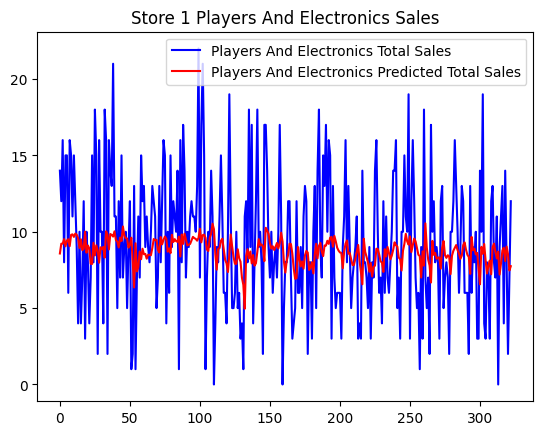

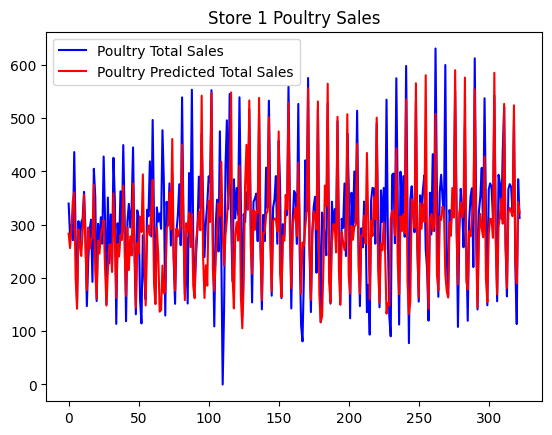

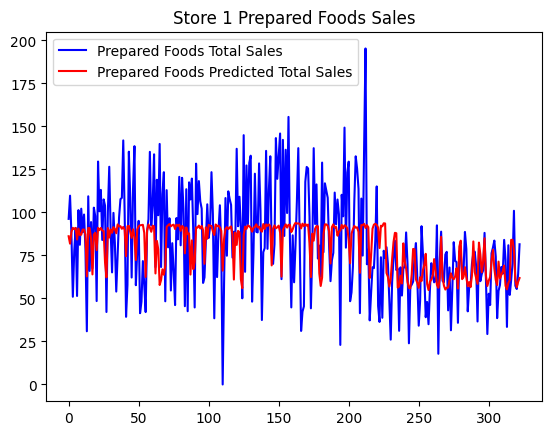

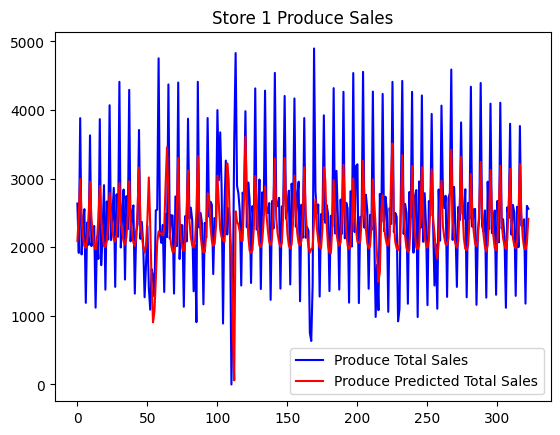

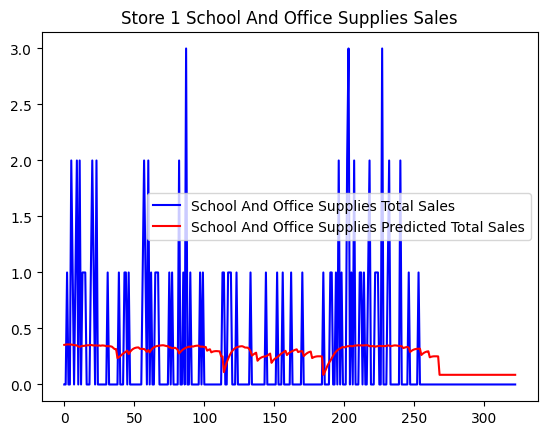

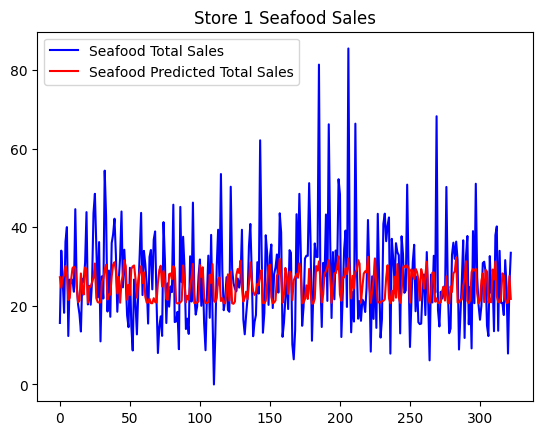

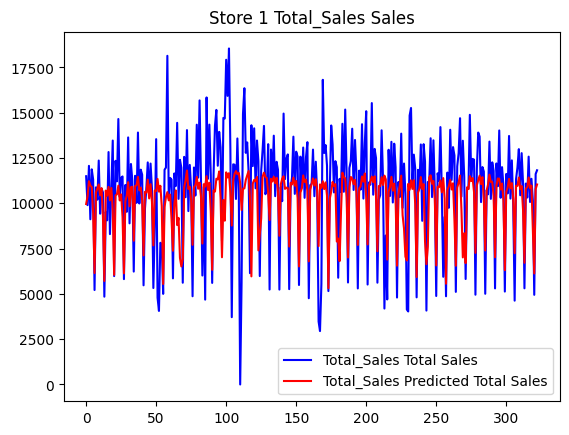

In [7]:
test_data, predictions, names = [], [], []
for i in range(1, 35):
    testing, prediction, name = predict_column(i, 40, 16)
    test_data.append(testing)
    predictions.append(prediction)
    names.append(name)
    print(f"Finished column {i}")
for i, v in enumerate(test_data):
    plt.plot(test_data[i], color='blue', label=f"{names[i]} Total Sales")
    plt.plot(predictions[i], color='red', label=f"{names[i]} Predicted Total Sales")
    plt.title(f"Store 1 {names[i]} Sales")
    plt.legend()
    plt.show()